In [1]:
from rdflib import Graph, Namespace, BNode
from rdflib.namespace import NamespaceManager
from uuid import uuid4
from jupyrest.model import BaseRdfModel
from typing import Set

g = Graph()

In [2]:
customers = Namespace("customers/")
services = Namespace("services/")
replicas = Namespace("replicas/")
nodes = Namespace("nodes/")
incidents = Namespace("incidents/")

nm = NamespaceManager(Graph())
nm.bind("customers", customers)
nm.bind("services", services)
nm.bind("replicas", replicas)
nm.bind("nodes", nodes)
nm.bind("incidents", incidents)
g.namespace_manager = nm

In [3]:
import io
import pydotplus
from IPython.display import display, Image
from rdflib.tools.rdf2dot import rdf2dot

def visualize(g):
    stream = io.StringIO()
    rdf2dot(g, stream, opts = {display})
    dg = pydotplus.graph_from_dot_data(stream.getvalue())
    png = dg.create_png()
    display(Image(png))

In [4]:
class Node(BaseRdfModel):
    node_id: str
    
    def uid(self):
        return self.node_id
    
    class Config:
        ns = Namespace("nodes/")
        
class Replica(BaseRdfModel):
    replica_id: str
    node: Node
    
    def uid(self):
        return self.replica_id
    
    class Config:
        ns = Namespace("replicas/")

class Service(BaseRdfModel):
    service_name: str
    replicas: Set[Replica]
    
    def uid(self):
        return self.service_name
    
    class Config:
        ns = Namespace("services/")

class Customer(BaseRdfModel):
    customer_name: str
    services: Set["Service"]

    def uid(self):
        return self.customer_name
    
    class Config:
        ns = Namespace("customers/")

In [5]:
node1 = Node(node_id="101")
node2 = Node(node_id="102")
node3 = Node(node_id="103")
node4 = Node(node_id="104")
node5 = Node(node_id="105")

replica1 = Replica(replica_id="001", node=node1)
replica2 = Replica(replica_id="002", node=node2)
replica3 = Replica(replica_id="003", node=node3)
replica4 = Replica(replica_id="004", node=node4)
replica5 = Replica(replica_id="005", node=node2)
replica6 = Replica(replica_id="006", node=node3)
replica7 = Replica(replica_id="007", node=node4)
replica8 = Replica(replica_id="008", node=node5)

serviceA = Service(service_name="service_A", replicas={replica1, replica2, replica3, replica4})
serviceB = Service(service_name="service_B", replicas={replica5, replica6, replica7, replica8})

customer1 = Customer(customer_name="Customer1", services={serviceA})
customer2 = Customer(customer_name="Customer2", services={serviceB})

In [8]:
l = list(customer1.to_triples())
l += customer2.to_triples()

In [12]:
customerA = customers.CustomerA
customerB = customers.CustomerB
serviceA = services.ServiceA
serviceB = services.ServiceB
r = [
    replicas['001'],
    replicas['002'],
    replicas['003'],
    replicas['004'],
    replicas['005'],
    replicas['006'],
    replicas['007'],
    replicas['008']

]
n = [
    nodes['101'],
    nodes['102'],
    nodes['103'],
    nodes['104'],
    nodes['105']
]
incident1 = incidents["133701"] # replica resends
incident2 = incidents["133702"] # slow disk
incident3 = incidents["133703"] # slow disk
incident4 = incidents["133704"] # replica resends
incident5 = incidents["133705"] # SLA dip

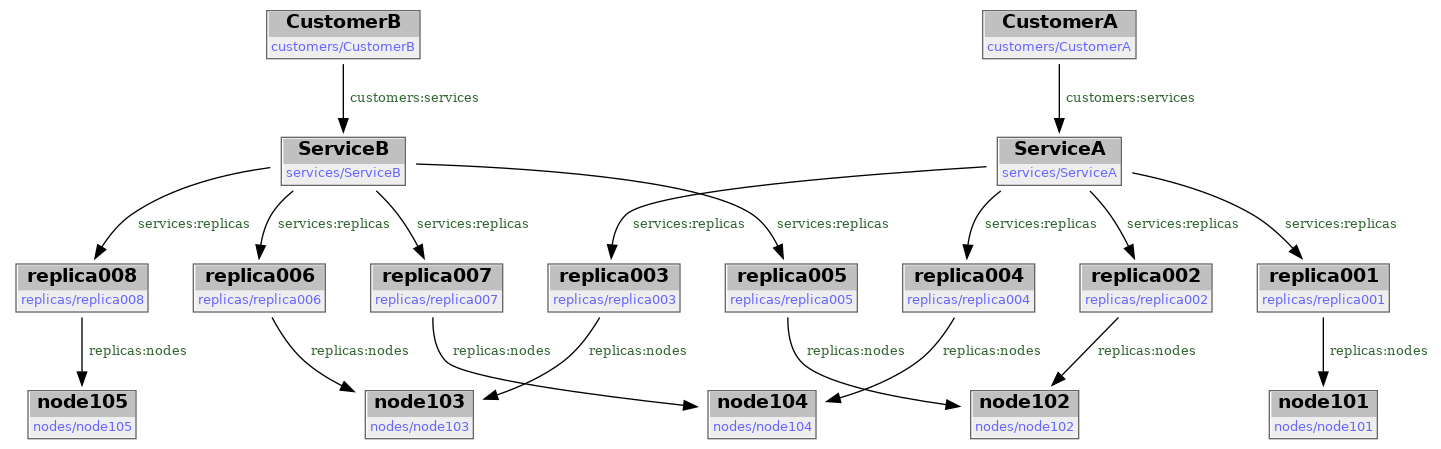

In [13]:
triples = [
    (customerA, customers.services, serviceA),
    (serviceA, services.replicas, replicas['replica001']),
    (serviceA, services.replicas, replicas['replica002']),
    (serviceA, services.replicas, replicas['replica003']),
    (serviceA, services.replicas, replicas['replica004']),
    (replicas['replica001'], replicas.nodes, nodes['node101']),
    (replicas['replica002'], replicas.nodes, nodes['node102']),
    (replicas['replica003'], replicas.nodes, nodes['node103']),
    (replicas['replica004'], replicas.nodes, nodes['node104']),
    
    (customerB, customers.services, serviceB),
    (serviceB, services.replicas, replicas['replica005']),
    (serviceB, services.replicas, replicas['replica006']),
    (serviceB, services.replicas, replicas['replica007']),
    (serviceB, services.replicas, replicas['replica008']),
    
    (replicas['replica005'], replicas.nodes, nodes['node102']),
    (replicas['replica006'], replicas.nodes, nodes['node103']),
    (replicas['replica007'], replicas.nodes, nodes['node104']),
    (replicas['replica008'], replicas.nodes, nodes['node105']),
]
for t in triples:
    g.add(t)
visualize(g)

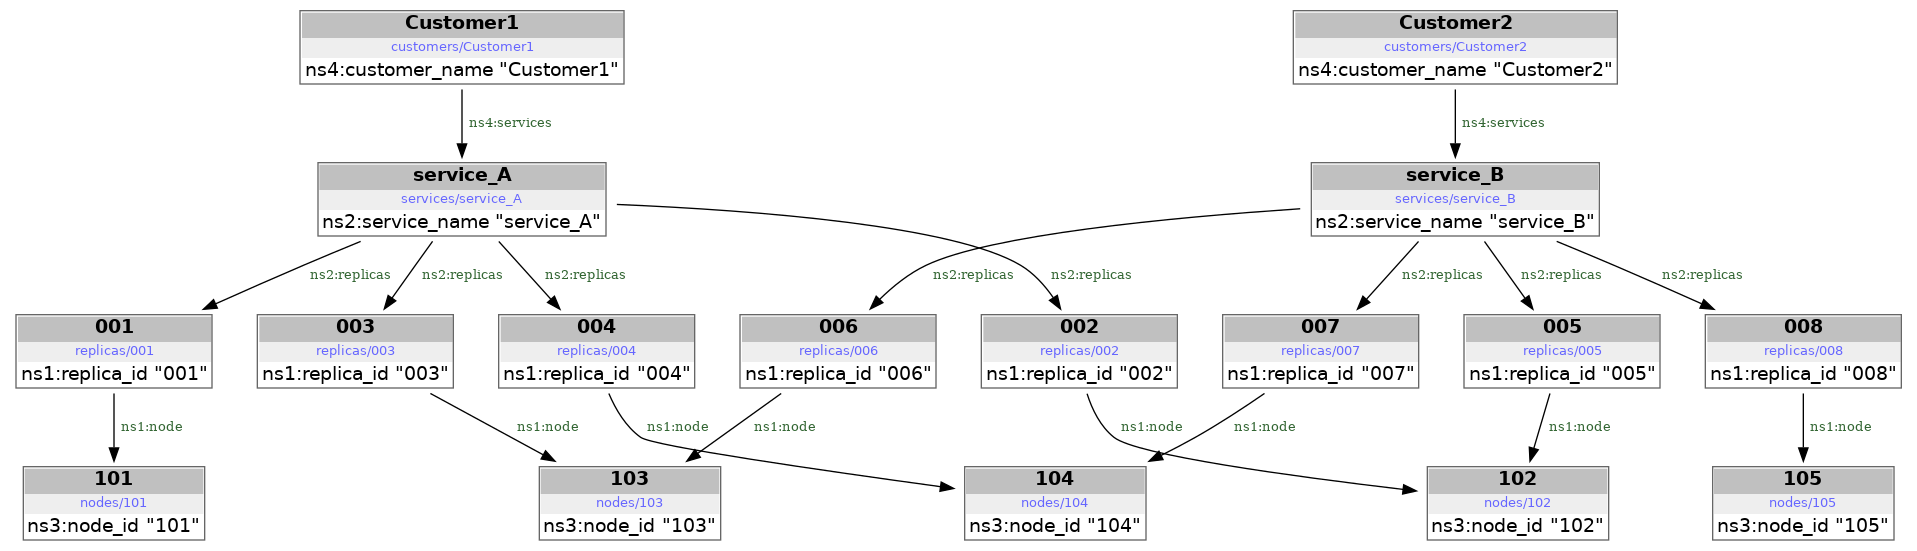

In [9]:
g = Graph()
for t in l:
    g.add(t)
visualize(g)

In [14]:
for i in range(4):
    print(f"(replicas['00{i+1}'], replicas.OnNode, nodes['10{i+1}']),")

(replicas['001'], replicas.OnNode, nodes['101']),
(replicas['002'], replicas.OnNode, nodes['102']),
(replicas['003'], replicas.OnNode, nodes['103']),
(replicas['004'], replicas.OnNode, nodes['104']),


In [26]:
from pydantic import BaseModel
from typing import Set, List, Dict

class Foo(BaseModel):
    a: str
    b: bool
    c: Set[int]
    d: List[int]
    f: Dict
    e: Dict
    g: Set[bool]
    h: "Foo"
        
    def uid(self):
        return self.a

    class Config:
        ns = Namespace("replicas")

In [27]:
Foo.Config

__main__.Foo.Config

In [17]:
Foo.__fields__['c'].infer

<bound method ModelField.infer of <class 'pydantic.fields.ModelField'>>

In [18]:
Foo.__fields__

{'a': ModelField(name='a', type=str, required=True),
 'b': ModelField(name='b', type=bool, required=True),
 'c': ModelField(name='c', type=Set[int], required=True),
 'd': ModelField(name='d', type=List[int], required=True),
 'f': ModelField(name='f', type=Mapping[Any, VT], required=True),
 'e': ModelField(name='e', type=Mapping[Any, VT], required=True),
 'g': ModelField(name='g', type=Set[bool], required=True),
 'h': ModelField(name='h', type=Foo, required=True)}

In [ ]:
def to_triples(obj: BaseModel)